In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy
import pandas as pd
import warnings
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier

# Segmenting Customers based upon their buying behaviour and geographical segmenting

## Preprocessing

In [ ]:
warnings.filterwarnings('ignore')

df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Online Retail.xlsx")
df.head()

,InvoiceNo,StockCode,lower,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,white hanging heart t-light holder,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,white metal lantern,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,cream cupid hearts coat hanger,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,knitted union flag hot water bottle,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,red woolly hottie white heart.,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


It took a few minutes to load the data, so we keep a copy as a backup.

In [ ]:
df1 = df

In [ ]:
df1.Country.nunique()

38

In [ ]:
df1.Country.unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [ ]:
customer_country=df1[['Country','CustomerID']].drop_duplicates()

customer_country.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)

,Country,CustomerID
36,United Kingdom,3950
14,Germany,95
13,France,87
31,Spain,31
3,Belgium,25
33,Switzerland,21
27,Portugal,19
19,Italy,15
12,Finland,12
1,Austria,11


## United Kingdom

More than 90% of the customers in the data are from United Kingdom, There’s some research indicating that customer clusters vary by geography, so showing the customer types within the country : United Kingdom

In [ ]:
df1 = df1.loc[df1['Country'] == 'United Kingdom']

Check whether there are missing values in each column.

There are 133600 missing values in CustomerID column, since our analysis is based on customers, we will remove these missing values.

In [ ]:
df1.isnull().sum(axis=0)

InvoiceNo           0
StockCode           0
lower          493807
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133600
Country             0
dtype: int64

In [ ]:
df1 = df1[pd.notnull(df1['CustomerID'])]
df1.isnull().sum(axis=0)

InvoiceNo           0
StockCode           0
lower          360581
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID          0
Country             0
dtype: int64

Check the min and max values in Unit price column

In [ ]:
df1.UnitPrice.min()

0.0

In [ ]:
df1.Quantity.min()

-80995

Removing the negative values in Quantity column

In [ ]:
df1 = df1[(df1['Quantity']>0)]
df1.Quantity.min()

1

After cleaning up, we now deal with 354345 rows and 9 columns

In [ ]:
df1.shape

(354345, 9)

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354345 entries, 0 to 541893
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    354345 non-null  object        
 1   StockCode    354345 non-null  object        
 2   lower        1285 non-null    object        
 3   Description  354345 non-null  object        
 4   Quantity     354345 non-null  int64         
 5   InvoiceDate  354345 non-null  datetime64[ns]
 6   UnitPrice    354345 non-null  float64       
 7   CustomerID   354345 non-null  float64       
 8   Country      354345 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 27.0+ MB


Checking unique value for each column

In [ ]:
def unique_counts(df1):
   for i in df1.columns:
       count = df1[i].nunique()
       print(i, ": ", count)
unique_counts(df1)

InvoiceNo :  16649
StockCode :  3645
lower :  713
Description :  3844
Quantity :  294
InvoiceDate :  15615
UnitPrice :  403
CustomerID :  3921
Country :  1


In [ ]:
df1.head()

,InvoiceNo,StockCode,lower,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,white hanging heart t-light holder,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,white metal lantern,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,cream cupid hearts coat hanger,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,knitted union flag hot water bottle,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,red woolly hottie white heart.,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Adding a column for total price

In [ ]:
df1['TotalPrice'] = df1['Quantity'] * df1['UnitPrice']
df1.head()

,InvoiceNo,StockCode,lower,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,white hanging heart t-light holder,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,white metal lantern,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,cream cupid hearts coat hanger,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,knitted union flag hot water bottle,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,red woolly hottie white heart.,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


Find out first and last order date in the data

In [ ]:
df1['InvoiceDate'].min()

Timestamp('2010-12-01 08:26:00')

In [ ]:
df1['InvoiceDate'].max()

Timestamp('2011-12-09 12:49:00')

Since recency is calculated for a point in time. The last invoice date is 2011-12-09, this is the date we will use to calculate recency.

In [ ]:
NOW = dt.datetime(2011,12,10)

In [ ]:
NOW

datetime.datetime(2011, 12, 10, 0, 0)

In [ ]:
df1['InvoiceDate'] = pd.to_datetime(df1['InvoiceDate'])

Creating a RFM (Recency - Frequency - Monetary Value) table

In [ ]:
rfmTable = df1.groupby('CustomerID').agg({'InvoiceDate': lambda x: (NOW - x.max()).days, # Recency
                                        'InvoiceNo': lambda x: len(x),      # Frequency
                                        'TotalPrice': lambda x: x.sum()}) # Monetary Value

rfmTable['InvoiceDate'] = rfmTable['InvoiceDate'].astype(int)
rfmTable.rename(columns={'InvoiceDate': 'recency',
                         'InvoiceNo': 'frequency',
                         'TotalPrice': 'monetary_value'}, inplace=True)

Calculating RFM metrics for each customer

In [ ]:
rfmTable.head()

,recency,frequency,monetary_value
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,103,4196.01
12748.0,0,4596,33719.73
12749.0,3,199,4090.88
12820.0,3,59,942.34


Interpretation:

CustomerID 12346 has frequency:1, monetary value:$77183.60 and recency:324 days.

CustomerID 12747 has frequency: 103, monetary value: $4196.01 and recency: 1 day

Let's check the details of the first customer.

In [ ]:
first_customer = df1[df1['CustomerID']== 12346.0]
first_customer

,InvoiceNo,StockCode,lower,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
61619,541431,23166,NaN,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,77183.6


The first customer has shopped only once, bought one item at a huge quantity(74215). The unit price is very low, seems a clearance sale or the customer may be a wholesaler

In [ ]:
(NOW - dt.datetime(2011,1,18)).days==326

True

Splitting metrics into segments by using tertiles, that is dividing 3-quantiles, that is splitting into three equal divisions

In [ ]:
quantiles = rfmTable.quantile(q=[0.33,0.67])
quantiles

,recency,frequency,monetary_value
0.33,24.0,23.0,370.672
0.67,92.0,74.0,1140.266


In [ ]:
quantiles = quantiles.to_dict()
quantiles

{'recency': {0.33: 24.0, 0.67: 92.0},
 'frequency': {0.33: 23.0, 0.67: 74.0},
 'monetary_value': {0.33: 370.672, 0.67: 1140.266}}

Creating a segmented RFM table

In [ ]:
segmented_rfm = rfmTable

In [ ]:
segmented_rfm

,recency,frequency,monetary_value
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,103,4196.01
12748.0,0,4596,33719.73
12749.0,3,199,4090.88
12820.0,3,59,942.34
...,...,...,...
18280.0,277,10,180.60
18281.0,180,7,80.82
18282.0,7,12,178.05


Lowest recency, highest frequency and monetary can be considered as the best customers for our company

In [ ]:
def RScore(x,p,d):
    if x <= d[p][0.33]:
        return 1
    elif x <= d[p][0.67]:
        return 2
    else:
        return 3

def FMScore(x,p,d):
    if x <= d[p][0.33]:
        return 3
    elif x <= d[p][0.67]:
        return 2
    else:
        return 1

In [ ]:
segmented_rfm['r_quartile'] = segmented_rfm['recency'].apply(RScore, args=('recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))

Add segment numbers to the RFM table

In [ ]:
segmented_rfm.head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile
CustomerID,,,,,,
12346.0,325,1,77183.60,3,3,1
12747.0,2,103,4196.01,1,1,1
12748.0,0,4596,33719.73,1,1,1
12749.0,3,199,4090.88,1,1,1
12820.0,3,59,942.34,1,2,2


RFM segments split your customer base into an imaginary 3D cube. It is hard to visualize. However, we can sort it out.

In [ ]:
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) \
                            + segmented_rfm.f_quartile.map(str) \
                            + segmented_rfm.m_quartile.map(str)
segmented_rfm.head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,
12346.0,325,1,77183.60,3,3,1,331
12747.0,2,103,4196.01,1,1,1,111
12748.0,0,4596,33719.73,1,1,1,111
12749.0,3,199,4090.88,1,1,1,111
12820.0,3,59,942.34,1,2,2,122


Apparently, the first customer is not our best customer at all.

Here is top 10 of our best customers!

Loyal and Regular Customers with high demands of expensive goods

In [ ]:
segmented_rfm[segmented_rfm['RFMScore']=='111'].sort_values('monetary_value', ascending=False).head(10)

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,
18102.0,0,431,259657.30,1,1,1,111
17450.0,8,337,194550.79,1,1,1,111
17511.0,2,963,91062.38,1,1,1,111
16684.0,4,277,66653.56,1,1,1,111
14096.0,4,5111,65164.79,1,1,1,111
13694.0,3,568,65039.62,1,1,1,111
15311.0,0,2379,60767.90,1,1,1,111
13089.0,2,1818,58825.83,1,1,1,111
15769.0,7,130,56252.72,1,1,1,111


Writing a function to segment customer types of each country given the segmented rfm table as input and classifying each customer type based on the tertiles/quantiles

In [ ]:
def customer_segmentation_rfm(rfm):
  rfm['Label'] = -1
  rfm['Customer Type'] = 's'
  rfm_arr_score = rfm['RFMScore'].values
  rfm_arr_label = rfm['Label'].values
  rfm_arr_ct = rfm['Customer Type'].values
  for i in range(len(rfm_arr_score)):
    rfm_arr_score[i] = int(rfm_arr_score[i])

  for i in range(len(rfm_arr_score)):
    if (rfm_arr_score[i] == 231 or rfm_arr_score[i]== 131 or rfm_arr_score[i]== 331) :
      rfm_arr_label[i] = 1
      rfm_arr_ct[i] = 'WholeSaler or Corporate Gifter'
    elif (rfm_arr_score[i] == 113 or rfm_arr_score[i]== 213) :
      rfm_arr_label[i] = 2
      rfm_arr_ct[i] = 'Regular customer with interest towards affordable gifting'
    elif (rfm_arr_score[i] == 111 or rfm_arr_score[i]== 211) :
      rfm_arr_label[i] = 3
      rfm_arr_ct[i] = 'Regular Customer with high demand of expensive gifts'
    elif rfm_arr_score[i] == 122 or rfm_arr_score[i]== 222 :
      rfm_arr_label[i] = 4
      rfm_arr_ct[i] = 'Moderate Customer with moderate level demands'
    elif rfm_arr_score[i] == 133 or rfm_arr_score[i] == 233 :
      rfm_arr_label[i] = 5
      rfm_arr_ct[i] = 'Potential emerging customer, inprofitable right now but can be profitable in coming times '
    elif rfm_arr_score[i] == 212 or rfm_arr_score[i]== 112 :
      rfm_arr_label[i] = 6
      rfm_arr_ct[i] = 'Regular customer with high demand of average price gifts'
    elif rfm_arr_score[i] == 132 or rfm_arr_score[i]== 232 or rfm_arr_score[i]== 123 or rfm_arr_score[i]== 223 :
      rfm_arr_label[i] = 7
      rfm_arr_ct[i] = 'Emerging Customer, profitable with moderate buying demands '
    elif rfm_arr_score[i] == 121 or rfm_arr_score[i]== 221 :
      rfm_arr_label[i] = 8
      rfm_arr_ct[i] = 'Retailers or the ones with shops in city who buy weekly or monthly to run their shops'
    else :
      rfm_arr_label[i] = 9
      rfm_arr_ct[i] = 'Nearly lost or inactive customers, not bought anything since a long time'

  return rfm


In [ ]:
customer_segmentation_rfm(segmented_rfm)

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore,Label,Customer Type
CustomerID,,,,,,,,,
12346.0,325,1,77183.60,3,3,1,331,1,WholeSaler or Corporate Gifter
12747.0,2,103,4196.01,1,1,1,111,3,Regular Customer with high demand of expensive...
12748.0,0,4596,33719.73,1,1,1,111,3,Regular Customer with high demand of expensive...
12749.0,3,199,4090.88,1,1,1,111,3,Regular Customer with high demand of expensive...
12820.0,3,59,942.34,1,2,2,122,4,Moderate Customer with moderate level demands
...,...,...,...,...,...,...,...,...,...
18280.0,277,10,180.60,3,3,3,333,9,"Nearly lost or inactive customers, not bought ..."
18281.0,180,7,80.82,3,3,3,333,9,"Nearly lost or inactive customers, not bought ..."
18282.0,7,12,178.05,1,3,3,133,5,"Potential emerging customer, inprofitable righ..."


Writing a function to plot a 3d scatter graph given the segmented rfm table with labels and clustering similar customers

In [ ]:
def plot(segmented_rfm):
  # Separate labels and features
  labels = segmented_rfm["Label"]
  features = segmented_rfm.drop(columns = ['Label', 'recency', 'frequency', 'monetary_value', 'RFMScore', 'Customer Type'])

  kmeans = KMeans(n_clusters=labels.nunique(), random_state=42)
  kmeans.fit(features)
  predicted_labels = kmeans.labels_

  fig = px.scatter_3d(features, x=features.columns[0], y=features.columns[1], z=features.columns[2], color=predicted_labels)

  # Creating a scatter plot of the features with different colors for each predicted label
  return fig.show()


In [ ]:
plot(segmented_rfm)

## Germany

In [ ]:
def customer_segmentation(country,df):
  df_seg = df.copy()
  df_seg = df_seg.loc[df_seg['Country'] == country ]
  if df_seg.isnull().sum(axis=0).CustomerID > 0 :
    df_seg = df_seg[pd.notnull(df_seg['CustomerID'])]
  if df_seg.Quantity.min() < 0 :
    df_seg = df_seg[df_seg['Quantity'] > 0]
  #print(df_seg.shape)
  #print(df_seg.info())
  #print(unique_counts(df_seg))
  df_seg['TotalPrice'] = df_seg['Quantity'] * df_seg['UnitPrice']
  #print(df_seg.head())
  df_seg['InvoiceDate'] = pd.to_datetime(df_seg['InvoiceDate'])
  rfmtable_seg = df_seg.groupby('CustomerID').agg({'InvoiceDate': lambda x: (NOW - x.max()).days, # Recency
                                        'InvoiceNo': lambda x: len(x),      # Frequency
                                        'TotalPrice': lambda x: x.sum()}) # Monetary Value

  rfmtable_seg['InvoiceDate'] = rfmtable_seg['InvoiceDate'].astype(int)
  rfmtable_seg.rename(columns={'InvoiceDate': 'recency',
                         'InvoiceNo': 'frequency',
                         'TotalPrice': 'monetary_value'}, inplace=True)
  quantiles_seg = rfmtable_seg.quantile(q=[0.33, 0.67])
  quantiles_seg = quantiles_seg.to_dict()
  #print(quantiles_seg)
  segmented_rfm_seg = rfmtable_seg
  segmented_rfm_seg['r_quartile'] = segmented_rfm_seg['recency'].apply(RScore, args=('recency',quantiles,))
  segmented_rfm_seg['f_quartile'] = segmented_rfm_seg['frequency'].apply(FMScore, args=('frequency',quantiles,))
  segmented_rfm_seg['m_quartile'] = segmented_rfm_seg['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))
  segmented_rfm_seg['RFMScore'] = segmented_rfm_seg.r_quartile.map(str) \
                            + segmented_rfm_seg.f_quartile.map(str) \
                            + segmented_rfm_seg.m_quartile.map(str)
  return segmented_rfm_seg.head()


In [ ]:
segmented_rfm_germany = customer_segmentation('Germany', df)
segmented_rfm_germany

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,
12426.0,194,30,582.73,3,2,2,322
12427.0,21,31,825.80,1,2,2,122
12468.0,187,38,729.54,3,2,2,322
12471.0,2,460,19824.05,1,1,1,111
12472.0,32,339,6572.11,2,1,1,211


In [ ]:
customer_segmentation_rfm(segmented_rfm_germany)

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore,Label,Customer Type
CustomerID,,,,,,,,,
12426.0,194,30,582.73,3,2,2,322,9,"Nearly lost or inactive customers, not bought ..."
12427.0,21,31,825.80,1,2,2,122,4,Moderate Customer with moderate level demands
12468.0,187,38,729.54,3,2,2,322,9,"Nearly lost or inactive customers, not bought ..."
12471.0,2,460,19824.05,1,1,1,111,3,Regular Customer with high demand of expensive...
12472.0,32,339,6572.11,2,1,1,211,3,Regular Customer with high demand of expensive...


In [ ]:
plot(segmented_rfm_germany)

## France

In [ ]:
segmented_rfm_france = customer_segmentation('France', df)

In [ ]:
segmented_rfm_france

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,
12413.0,66,38,758.10,2,2,2,222
12437.0,1,200,4951.41,1,1,1,111
12441.0,366,11,173.55,3,3,3,333
12488.0,9,55,1298.66,1,2,1,121
12489.0,336,15,334.93,3,3,3,333


In [ ]:
segmented_rfm_france_new = customer_segmentation_rfm(segmented_rfm_france)

In [ ]:
segmented_rfm_france_new

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore,Label,Customer Type
CustomerID,,,,,,,,,
12413.0,66,38,758.10,2,2,2,222,4,Moderate Customer with moderate level demands
12437.0,1,200,4951.41,1,1,1,111,3,Regular Customer with high demand of expensive...
12441.0,366,11,173.55,3,3,3,333,9,"Nearly lost or inactive customers, not bought ..."
12488.0,9,55,1298.66,1,2,1,121,8,Retailers or the ones with shops in city who b...
12489.0,336,15,334.93,3,3,3,333,9,"Nearly lost or inactive customers, not bought ..."


In [ ]:
plot(segmented_rfm_france_new)

## Plots for Rest of the Countries

In [ ]:
df_copy = df.copy()
df_copy = df_copy[df_copy['Country'] != 'Hong Kong']

countries = df_copy.Country.unique()


for i in range(len(countries)):

  segmented_rfm_country=customer_segmentation(countries[i],df_copy)

  segmented_rfm_country_new = customer_segmentation_rfm(segmented_rfm_country)
  print(countries[i])

  plot(segmented_rfm_country_new)


United Kingdom


France


Australia


Netherlands


Germany


Norway


EIRE


Switzerland


Spain


Poland


Portugal


Italy


Belgium


Lithuania


Japan


Iceland


Channel Islands


Denmark


Cyprus


Sweden


Austria


Israel


Finland


Bahrain


Greece


Singapore


Lebanon


United Arab Emirates


Saudi Arabia


Czech Republic


Canada


Unspecified


Brazil


USA


European Community


Malta


RSA


# Implementing classifiers for Segmentation, with labels being countries

## PreProcessing

In [ ]:
segment_df = df.copy()

In [ ]:
segment_df

,InvoiceNo,StockCode,lower,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,white hanging heart t-light holder,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,white metal lantern,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,cream cupid hearts coat hanger,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,knitted union flag hot water bottle,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,red woolly hottie white heart.,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,NaN,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,NaN,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,NaN,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,NaN,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [ ]:
segment_df.isnull().sum()

InvoiceNo           0
StockCode           0
lower          540093
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
#dropping the 'lower' column since it contains many null values and hence it is of no use to us for the classification

segment_df_2 = segment_df.drop(columns = ['lower'])

In [ ]:
segment_df_2.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
segment_df_2 = segment_df_2[pd.notnull(segment_df_2['CustomerID'])]

In [ ]:
segment_df_2.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [ ]:
# Remove cancelled orders
segment_df_2 = segment_df_2[segment_df_2["Quantity"] > 0]

# Convert the InvoiceDate column to datetime
segment_df_2["InvoiceDate"] = pd.to_datetime(segment_df_2["InvoiceDate"])

# Create a TotalPrice column
segment_df_2["TotalPrice"] = segment_df_2["Quantity"] * segment_df_2["UnitPrice"]

In [ ]:
rfm_segment_cust = segment_df_2.groupby('CustomerID').agg({'InvoiceDate': lambda x: (NOW - x.max()).days, # Recency
                                        'InvoiceNo': lambda x: len(x),      # Frequency
                                        'TotalPrice': lambda x: x.sum(),    # Monetary Value
                                        'Country' : lambda x: x })
rfm_segment_cust['InvoiceDate'] = rfm_segment_cust['InvoiceDate'].astype(int)
rfm_segment_cust.rename(columns={'InvoiceDate': 'recency',
                         'InvoiceNo': 'frequency',
                         'TotalPrice': 'monetary_value'}, inplace=True)

In [ ]:
rfm_segment_cust

,recency,frequency,monetary_value,Country
CustomerID,,,,
12346.0,325,1,77183.60,United Kingdom
12347.0,2,182,4310.00,"[Iceland, Iceland, Iceland, Iceland, Iceland, ..."
12348.0,75,31,1797.24,"[Finland, Finland, Finland, Finland, Finland, ..."
12349.0,18,73,1757.55,"[Italy, Italy, Italy, Italy, Italy, Italy, Ita..."
12350.0,310,17,334.40,"[Norway, Norway, Norway, Norway, Norway, Norwa..."
...,...,...,...,...
18280.0,277,10,180.60,"[United Kingdom, United Kingdom, United Kingdo..."
18281.0,180,7,80.82,"[United Kingdom, United Kingdom, United Kingdo..."
18282.0,7,12,178.05,"[United Kingdom, United Kingdom, United Kingdo..."


In [ ]:
rfm_segment_cust['Country'].values

array(['United Kingdom',
       array(['Iceland', 'Iceland', 'Iceland', 'Iceland', 'Iceland', 'Iceland',
              'Iceland', 'Iceland', 'Iceland', 'Iceland', 'Iceland', 'Iceland',
              'Iceland', 'Iceland', 'Iceland', 'Iceland', 'Iceland', 'Iceland',
              'Iceland', 'Iceland', 'Iceland', 'Iceland', 'Iceland', 'Iceland',
              'Iceland', 'Iceland', 'Iceland', 'Iceland', 'Iceland', 'Iceland',
              'Iceland', 'Iceland', 'Iceland', 'Iceland', 'Iceland', 'Iceland',
              'Iceland', 'Iceland', 'Iceland', 'Iceland', 'Iceland', 'Iceland',
              'Iceland', 'Iceland', 'Iceland', 'Iceland', 'Iceland', 'Iceland',
              'Iceland', 'Iceland', 'Iceland', 'Iceland', 'Iceland', 'Iceland',
              'Iceland', 'Iceland', 'Iceland', 'Iceland', 'Iceland', 'Iceland',
              'Iceland', 'Iceland', 'Iceland', 'Iceland', 'Iceland', 'Iceland',
              'Iceland', 'Iceland', 'Iceland', 'Iceland', 'Iceland', 'Iceland',
              '

In [ ]:
for i in range(len(rfm_segment_cust['Country'].values)) :
  if type(rfm_segment_cust['Country'].values[i]) == str:
    continue
  else :
    for j in range(len(rfm_segment_cust['Country'].values[i])) :
      rfm_segment_cust['Country'].values[i] = rfm_segment_cust['Country'].values[i][j]
      break

In [ ]:
rfm_segment_cust

,recency,frequency,monetary_value,Country
CustomerID,,,,
12346.0,325,1,77183.60,United Kingdom
12347.0,2,182,4310.00,Iceland
12348.0,75,31,1797.24,Finland
12349.0,18,73,1757.55,Italy
12350.0,310,17,334.40,Norway
...,...,...,...,...
18280.0,277,10,180.60,United Kingdom
18281.0,180,7,80.82,United Kingdom
18282.0,7,12,178.05,United Kingdom


In [ ]:
rfm_segment_cust.nunique()

recency            304
frequency          461
monetary_value    4277
Country             37
dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    rfm_segment_cust[["recency", "frequency", "monetary_value"]],
    rfm_segment_cust["Country"],
    test_size=0.2,
    random_state=42
)

## Random Forest Classifier

In [ ]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

# Evaluating the model's performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average="weighted"))
print("Recall:", recall_score(y_test, y_pred, average="weighted"))
print("F1 Score:", f1_score(y_test, y_pred, average="weighted"))

Accuracy: 0.8870967741935484
Precision: 0.7908068241078745
Recall: 0.8870967741935484
F1 Score: 0.8361889007050297


In [ ]:
customer_types = rfc.predict(rfm_segment_cust[["recency", "frequency", "monetary_value"]])
rfm_segment_cust["CustomerType"] = customer_types

<Axes: title={'center': 'Customer Types'}>

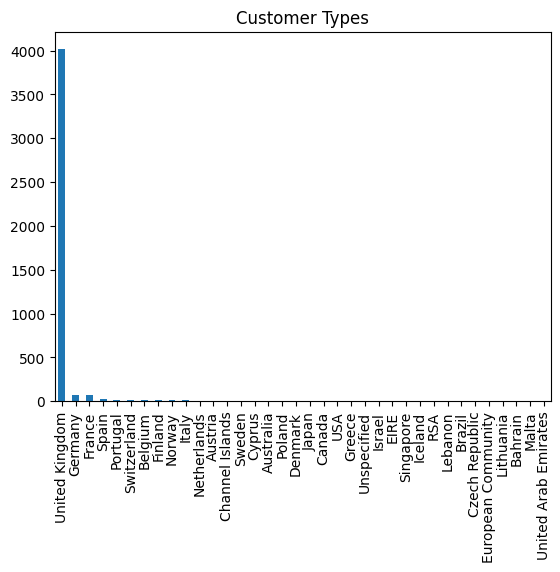

In [ ]:
customer_type_counts = rfm_segment_cust["CustomerType"].value_counts()
customer_type_counts.plot(kind="bar", title="Customer Types")

## SVD and KNN Classifier

In [ ]:
svd = TruncatedSVD(n_components=2, random_state=42)
X_train_svd = svd.fit_transform(X_train)
X_test_svd = svd.transform(X_test)

knn = KNeighborsClassifier()
knn.fit(X_train_svd, y_train)
knn_y_pred = knn.predict(X_test_svd)
knn_accuracy = accuracy_score(y_test, knn_y_pred)
knn_precision = precision_score(y_test, knn_y_pred, average='weighted')
knn_recall = recall_score(y_test, knn_y_pred, average='weighted')
knn_f1_score = f1_score(y_test, knn_y_pred, average='weighted')

In [ ]:
print("\nSVD and KNN Classifier:")
print("Accuracy:", knn_accuracy)
print("Precision Score:", knn_precision)
print("Recall:", knn_recall)
print("F1 Score:", knn_f1_score)


SVD and KNN Classifier:
Accuracy: 0.8847926267281107
Precision Score: 0.7905785970302098
Recall: 0.8847926267281107
F1 Score: 0.8350365621443783


## PCA and Decision Tree Classifier

In [ ]:
pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train_pca, y_train)
dtc_y_pred = dtc.predict(X_test_pca)
dtc_accuracy = accuracy_score(y_test, dtc_y_pred)
dtc_precision = precision_score(y_test, dtc_y_pred, average='weighted')
dtc_recall = recall_score(y_test, dtc_y_pred, average='weighted')
dtc_f1_score = f1_score(y_test, dtc_y_pred, average='weighted')

In [ ]:
print("\nPCA and Decision Tree Classifier:")
print("Accuracy:", dtc_accuracy)
print("Precision Score:", dtc_precision)
print("Recall:", dtc_recall)
print("F1 Score:", dtc_f1_score)


PCA and Decision Tree Classifier:
Accuracy: 0.8052995391705069
Precision Score: 0.7935128256371673
Recall: 0.8052995391705069
F1 Score: 0.7993335300231158


## LDA and KNN Classifier

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

knn_lda = KNeighborsClassifier()
knn_lda.fit(X_train_lda, y_train)
knn_lda_y_pred = knn_lda.predict(X_test_lda)
knn_lda_accuracy = accuracy_score(y_test, knn_lda_y_pred)
knn_lda_precision = precision_score(y_test, knn_lda_y_pred, average='weighted')
knn_lda_recall = recall_score(y_test, knn_lda_y_pred, average='weighted')
knn_lda_f1_score = f1_score(y_test, knn_lda_y_pred, average='weighted')

In [ ]:
print("\nLDA and KNN Classifier:")
print("Accuracy:", knn_lda_accuracy)
print("Precision Score:", knn_lda_precision)
print("Recall:", knn_lda_recall)
print("F1 Score:", knn_lda_f1_score)


LDA and KNN Classifier:
Accuracy: 0.8847926267281107
Precision Score: 0.7914946788344165
Recall: 0.8847926267281107
F1 Score: 0.8355472878704604
